In [1]:
import numpy as np
import argparse
import imutils
import cv2
import motion_interpretation
from scipy.stats.mstats import mode as statics_mode

from HUB_dictionary.motion_dictionary  import Motion_Dictionary
from HUB_dictionary.path_dictionary    import Path_DTW_Dictionary
from HUB_dictionary.gesture_dictionary import Gesture_DTW_Dictionary
from HUB_Model.multi_recog import HaarCV_Recognizor, PureScrewDriverRecog

from com_func.conf import Conf

class Recog2Track():
    def __init__(self, mulRecog, modelNameList, path_recognition_Flag=True):
        ''' mulRecog = [M1, M2, ...]
            modelNameList = [str(M1), str(M2)...] '''
        self.numFrames = 0
        self.modelNameList = modelNameList
        self.modelNum = len(mulRecog)
        ##########################################

        # this is the collection that contains the obj center-point
        self.position = []

        # this is the motion- number representation with out any cut, trim,
        # this variable is used to output the training data or ...etc
        self.motionALL = [] # OutPutModel...

        # this variable is the same as above, just trimmed
        self.motionSeq = []

        # max likelihood for the most possible motion
        self.motionLikehoodSeq = []

        # this variable is contain the ref_img that for fast match
        self.refImgforMatch = []

        # this variable is contrain the Flag of state
        self.trackingFlag = []

        # According to how many obj , we init_corresponding variables
        #
        for i in range(self.modelNum):
            # Below structure is [ [] ,  []]
            # or [ 1,0  ] for Flag
            self.position.append([])
            self.motionALL.append([])
            self.motionSeq.append([])
            self.motionLikehoodSeq.append([])
            self.refImgforMatch.append([])
            self.trackingFlag.append(0)
        ###########################################
        self.path_recognition = path_recognition_Flag
        self.pathRegStr = "None"
        self.actionStr = "None"
        self.recogModels = mulRecog

    def perform_IMG_analysis(self, img):
        raw = img.copy()
        for model in self.recogModels:
            raw, tarBox = model.detect(raw)
            if len(tarBox)>0:
                position = ((tarBox[0]+tarBox[2])/2, (tarBox[1]+tarBox[3])/2)
            else :
                position = (0,0)
        return raw, position

    def tracking_mode(self,):
        pass

    def template_match(self, newImg,refImg , thresHold=0.85):
        '''
        res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
        threshold = 0.8
        loc = np.where( res >= threshold)
        -----------------------------------
        Output = NweImg and TarBox
        '''
        res = cv2.matchTemplate(newImg, refImg, cv2.TM_CCOEFF_NORMED)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        # if the match is quite  not like the original
        if max_val < thresHold:
            return newImg,[]

        # startX , startY
        top_left = max_loc
        h , w, _ = refImg.shape
        bottom_right = (top_left[0]+w,top_left[1]+h)
        
        cv2.rectangle(newImg, top_left, bottom_right, 255, 2)
        startX , startY = top_left[0], top_left[1]
        endX, endY = bottom_right
        tarBox = (startX, startY, endX, endY)
        print tarBox
        return newImg, tarBox


    def motion_feature_extraction(self, imgAFrecog ,pointsSet,modelID):
        '''
        imgAFrecog : the raw img after static recognition
        pointsSet  : the location of the objects
        modelID    : the name that we predifined when iniciation the class
        '''
        Dictionary = Motion_Dictionary()
        PathDictionary = Path_DTW_Dictionary()
        if len(pointsSet)>3 :
            last_point = pointsSet[-2]
            tmp_motion = motion_interpretation.interpreter(last_point,pointsSet[-1])
            #
            self.motionALL[modelID].append(tmp_motion) # this is all motion
            self.motionSeq[modelID].append(tmp_motion) # this is time-segment motion
            # Compute the max_Likelihood
            self.motionSeq[modelID]      = self.seq_clip(self.motionSeq[modelID],10)
            motionLikehood = statics_mode(self.motionSeq[modelID])[0]
            self.motionLikehoodSeq[modelID].append(motionLikehood)
            motionStr      = Dictionary.check(motionLikehood)
            # %.2f = float with 2 dicimal
            modelName = self.modelNameList[modelID]
            cv2.putText(imgAFrecog,
                "The %s is %s" % (modelName,motionStr),
                 (20, 50*(1+modelID)), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 6)
            '''
            if len(self.motionLikehoodSeq[modelID])>10 and (self.path_recognition is True):

                # put it in small LSTM or RNN for NPL
                # put it into DTW search/match
                PathRegStr_tmp = PathDictionary.search(self.motionLikehoodSeq[modelID][-7:])
                if PathRegStr_tmp == 'None':
                    pass
                else:
                    cv2.putText(imgAFrecog,
                        "The %s is %s" % (modelName, PathRegStr_tmp),
                        (20, 100*(1+modelID)), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 6)
                    self.pathRegStr = PathRegStr_tmp
            '''
            # This part spared by not doing path Recognition,
            # if we want to do path recog, please ref 2016MIT/Motion_Recognition
        return imgAFrecog

    def have_refimg(self, imgInput,tarBox,channels ):
        if channels==3:
            # process RBG, HSC, data (3 channels)
            return imgInput[tarBox[1]:tarBox[3],tarBox[0]:tarBox[2],:]
        else :
            # process depth data or gray-scale data
            return imgInput[tarBox[1]:tarBox[3],tarBox[0]:tarBox[2]]

    def seq_clip(self, inPut,seqLen):
        if len(inPut)<seqLen:
            return inPut
        return inPut[-seqLen:]

    def perform_VID_analysis(self, startFrame, endFrame, vid):
        '''vidObj based on the image io OBJ'''
        self.numFrames = startFrame
        imgSeq = []
        assert endFrame > startFrame and endFrame < vid.get_length()
        while self.numFrames <= endFrame:
            img = vid.get_data(self.numFrames)
            NewImg = img.copy()

            # this operation is to create a black board for print the text
            cv2.rectangle(NewImg,(0,0),(800,125),(10,10,10),-1)

            for modelID, model in enumerate(self.recogModels):
                ############################
                # add the criteria of Flag #
                ############################
                if self.trackingFlag[modelID]==0:
                    NewImg, tarBox = model.detect(NewImg)

                    ################################################################################
                    print 'recognitions mode'
                    print 'Processing : ( Model : {}, Frame : {} )'.format(modelID, self.numFrames)
                    if len(tarBox)>0: # obj been detected
                        assert len(tarBox)==4
                        position = ((tarBox[0]+tarBox[2])/2, (tarBox[0]+tarBox[2])/2)
                        self.position[modelID].append(position)
                        ################################
                        # output the refImg by objects #
                        ################################
                        self.refImgforMatch[modelID] = self.have_refimg(NewImg,tarBox,3)

                        #####################################
                        # if detected, than change the Flag #
                        # put # to disable tracking mode    #
                        #####################################
                        
                        #self.trackingFlag[modelID]=1

                    else: # Treat as Stationary
                        if len(self.position[modelID])>0:
                            self.position[modelID].append(self.position[modelID][-1])
                    NewImg = self.motion_feature_extraction(NewImg,self.position[modelID], modelID)

                    #

                elif self.trackingFlag[modelID]==1:
                    NewImg, tarBox = self.template_match(NewImg, self.refImgforMatch[modelID] )

                    ################################################################################
                    print ('tracking_mode')
                    print 'Processing : ( Model : {}, Frame : {} )'.format(modelID, self.numFrames)
                    if len(tarBox)>0: # obj been detected
                        assert len(tarBox)==4
                        position = ((tarBox[0]+tarBox[2])/2, (tarBox[0]+tarBox[2])/2)
                        self.position[modelID].append(position)
                        ################################
                        # output the refImg by objects #
                        ################################
                        self.refImgforMatch[modelID] = self.have_refimg(NewImg,tarBox,3)

                        #####################################
                        # if detected, than change the Flag #
                        #####################################
                        self.trackingFlag[modelID]=1

                    else: # Treat as Stationary
                        if len(self.position[modelID])>0:
                            self.position[modelID].append(self.position[modelID][-1])
                        #####################################
                        # if detected, than change the Flag #
                        #####################################
                        self.trackingFlag[modelID]=0  
                    NewImg = self.motion_feature_extraction(NewImg,self.position[modelID], modelID)
                    ################################################################################

                self.numFrames+=1
                imgSeq.append(NewImg)
        return imgSeq

    def perform_WebCam_analysis(self, capIMG):
        '''vidObj based on the image io OBJ'''
        NewImg = capIMG.copy()
        # for out put on the motino recognition
        cv2.rectangle(NewImg,(0,0),(800,125),(10,10,10),-1)
        for modelID, model in enumerate(self.recogModels):
            NewImg, tarBox = model.detect(NewImg)
            print 'Processing : ( Model : {}, Frame : {} )'.format(modelID, self.numFrames)
            if len(tarBox)>0: # obj been detected
                assert len(tarBox)==4
                position = ((tarBox[0]+tarBox[2])/2, (tarBox[0]+tarBox[2])/2)
                self.position[modelID].append(position)
            else: # Treat as Stationary
                if len(self.position[modelID])>0:
                    self.position[modelID].append(self.position[modelID][-1])
            NewImg = self.motion_feature_extraction(NewImg,self.position[modelID], modelID)
        self.numFrames+=1
        self.pathRegStr = 'None'
        return NewImg

    def reinitialising_parameter(self):
        self.position = []
        self.motionALL = [] # OutPutModel...
        self.motionSeq = []
        self.motionLikehoodSeq = []
        self.refImgforMatch = []
        for i in range(self.modelNum):
            self.position.append([])
            self.motionALL.append([])
            self.motionSeq.append([])
            self.motionLikehoodSeq.append([])
            self.refImgforMatch.append([])
        self.pathRegStr = "None"
        self.actionStr = "None"

    def feature_describe(self):
        return self.motionLikehoodSeq
    

In [2]:
# Testing Scrip Setting 
import imageio
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline


# MAC OS Retrival Model
model_1 = HaarCV_Recognizor()
    
model_2 = PureScrewDriverRecog(Conf('conf_hub/conf_pureScrewDriver_2.json'))
ReTesT = Recog2Track([model_1,model_2],['Hand', 'SkrewDriver'])
if os.name =='nt':
    vid = imageio.get_reader('D:/2016-01-21//10.167.10.158_01_20160121082638418_2.mp4')
else:
    vid = imageio.get_reader('/Users/kentchiu/MIT_Vedio/2016-01-21/'
                         '10.167.10.158_01_20160121082638418_2.mp4')
# notice _1.mp4 will not work
# need fine tuning 
output = ReTesT.perform_VID_analysis(250,400,vid)

/Users/kentchiu/Library/Application Support/imageio/ffmpeg/ffmpeg.osx
/Users/kentchiu/anaconda/lib/python2.7/site-packages/imageio/resources/ffmpeg/ffmpeg.osx
recognitions mode
Processing : ( Model : 0, Frame : 250 )
recognitions mode
Processing : ( Model : 1, Frame : 251 )
recognitions mode
Processing : ( Model : 0, Frame : 252 )
recognitions mode
Processing : ( Model : 1, Frame : 253 )
recognitions mode
Processing : ( Model : 0, Frame : 254 )
recognitions mode
Processing : ( Model : 1, Frame : 255 )
recognitions mode
Processing : ( Model : 0, Frame : 256 )
recognitions mode
Processing : ( Model : 1, Frame : 257 )
recognitions mode
Processing : ( Model : 0, Frame : 258 )
recognitions mode
Processing : ( Model : 1, Frame : 259 )
recognitions mode
Processing : ( Model : 0, Frame : 260 )
recognitions mode
Processing : ( Model : 1, Frame : 261 )
recognitions mode
Processing : ( Model : 0, Frame : 262 )
recognitions mode
Processing : ( Model : 1, Frame : 263 )
recognitions mode
Processing 

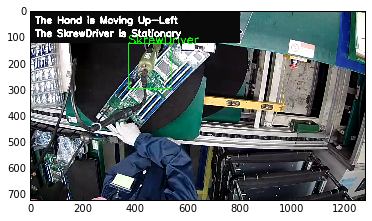

In [3]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def f(x):
    plt.imshow(output[x])

interact(f, x=35);

In [6]:

class Recog2Track():
    def __init__(self, mulRecog, modelNameList, path_recognition_Flag=True):
        ''' mulRecog = [M1, M2, ...]
            modelNameList = [str(M1), str(M2)...] '''
        self.numFrames = 0
        self.modelNameList = modelNameList
        self.modelNum = len(mulRecog)
        ##########################################

        # this is the collection that contains the obj center-point
        self.position = []

        # this is the motion- number representation with out any cut, trim,
        # this variable is used to output the training data or ...etc
        self.motionALL = [] # OutPutModel...

        # this variable is the same as above, just trimmed
        self.motionSeq = []

        # max likelihood for the most possible motion
        self.motionLikehoodSeq = []

        # this variable is contain the ref_img that for fast match
        self.refImgforMatch = []

        # this variable is contrain the Flag of state
        self.trackingFlag = []

        # According to how many obj , we init_corresponding variables
        #
        for i in range(self.modelNum):
            # Below structure is [ [] ,  []]
            # or [ 1,0  ] for Flag
            self.position.append([])
            self.motionALL.append([])
            self.motionSeq.append([])
            self.motionLikehoodSeq.append([])
            self.refImgforMatch.append([])
            self.trackingFlag.append(0)
        ###########################################
        self.path_recognition = path_recognition_Flag
        self.pathRegStr = "None"
        self.actionStr = "None"
        self.recogModels = mulRecog

    def perform_IMG_analysis(self, img):
        raw = img.copy()
        for model in self.recogModels:
            raw, tarBox = model.detect(raw)
            if len(tarBox)>0:
                position = ((tarBox[0]+tarBox[2])/2, (tarBox[1]+tarBox[3])/2)
            else :
                position = (0,0)
        return raw, position

    def tracking_mode(self,):
        pass

    def template_match(self, newImg,refImg , thresHold=0.85):
        '''
        res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
        threshold = 0.8
        loc = np.where( res >= threshold)
        -----------------------------------
        Output = NweImg and TarBox
        '''
        res = cv2.matchTemplate(newImg, refImg, cv2.TM_CCOEFF_NORMED)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        # if the match is quite  not like the original
        if max_val < thresHold:
            return newImg,[]

        # startX , startY
        top_left = max_loc
        h , w, _ = refImg.shape
        bottom_right = (top_left[0]+w,top_left[1]+h)
        
        cv2.rectangle(newImg, top_left, bottom_right, 100, 2)
        startX , startY = top_left[0], top_left[1]
        endX, endY = bottom_right
        tarBox = (startX, startY, endX, endY)
        print tarBox
        return newImg, tarBox


    def motion_feature_extraction(self, imgAFrecog ,pointsSet,modelID):
        '''
        imgAFrecog : the raw img after static recognition
        pointsSet  : the location of the objects
        modelID    : the name that we predifined when iniciation the class
        '''
        Dictionary = Motion_Dictionary()
        PathDictionary = Path_DTW_Dictionary()
        if len(pointsSet)>3 :
            last_point = pointsSet[-2]
            tmp_motion = motion_interpretation.interpreter(last_point,pointsSet[-1])
            #
            self.motionALL[modelID].append(tmp_motion) # this is all motion
            self.motionSeq[modelID].append(tmp_motion) # this is time-segment motion
            # Compute the max_Likelihood
            self.motionSeq[modelID]      = self.seq_clip(self.motionSeq[modelID],10)
            motionLikehood = statics_mode(self.motionSeq[modelID])[0]
            self.motionLikehoodSeq[modelID].append(motionLikehood)
            motionStr      = Dictionary.check(motionLikehood)
            # %.2f = float with 2 dicimal
            modelName = self.modelNameList[modelID]
            cv2.putText(imgAFrecog,
                "The %s is %s" % (modelName,motionStr),
                 (20, 50*(1+modelID)), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 6)
            '''
            if len(self.motionLikehoodSeq[modelID])>10 and (self.path_recognition is True):

                # put it in small LSTM or RNN for NPL
                # put it into DTW search/match
                PathRegStr_tmp = PathDictionary.search(self.motionLikehoodSeq[modelID][-7:])
                if PathRegStr_tmp == 'None':
                    pass
                else:
                    cv2.putText(imgAFrecog,
                        "The %s is %s" % (modelName, PathRegStr_tmp),
                        (20, 100*(1+modelID)), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 6)
                    self.pathRegStr = PathRegStr_tmp
            '''
            # This part spared by not doing path Recognition,
            # if we want to do path recog, please ref 2016MIT/Motion_Recognition
        return imgAFrecog

    def have_refimg(self, imgInput,tarBox,channels ):
        if channels==3:
            # process RBG, HSC, data (3 channels)
            return imgInput[tarBox[1]:tarBox[3],tarBox[0]:tarBox[2],:]
        else :
            # process depth data or gray-scale data
            return imgInput[tarBox[1]:tarBox[3],tarBox[0]:tarBox[2]]

    def seq_clip(self, inPut,seqLen):
        if len(inPut)<seqLen:
            return inPut
        return inPut[-seqLen:]

    def perform_VID_analysis(self, startFrame, endFrame, vid):
        '''vidObj based on the image io OBJ'''
        self.numFrames = startFrame
        imgSeq = []
        assert endFrame > startFrame and endFrame < vid.get_length()
        while self.numFrames <= endFrame:
            img = vid.get_data(self.numFrames)
            NewImg = img.copy()

            # this operation is to create a black board for print the text
            cv2.rectangle(NewImg,(0,0),(800,125),(10,10,10),-1)

            for modelID, model in enumerate(self.recogModels):
                ############################
                # add the criteria of Flag #
                ############################
                if self.trackingFlag[modelID]==0:
                    NewImg, tarBox = model.detect(NewImg)

                    ################################################################################
                    print 'recognitions mode'
                    print 'Processing : ( Model : {}, Frame : {} )'.format(modelID, self.numFrames)
                    if len(tarBox)>0: # obj been detected
                        assert len(tarBox)==4
                        position = ((tarBox[0]+tarBox[2])/2, (tarBox[0]+tarBox[2])/2)
                        self.position[modelID].append(position)
                        ################################
                        # output the refImg by objects #
                        ################################
                        self.refImgforMatch[modelID] = self.have_refimg(NewImg,tarBox,3)

                        #####################################
                        # if detected, than change the Flag #
                        # put # to disable tracking mode    #
                        #####################################
                        
                        self.trackingFlag[modelID]=1

                    else: # Treat as Stationary
                        if len(self.position[modelID])>0:
                            self.position[modelID].append(self.position[modelID][-1])
                    NewImg = self.motion_feature_extraction(NewImg,self.position[modelID], modelID)

                    #

                elif self.trackingFlag[modelID]==1:
                    NewImg, tarBox = self.template_match(NewImg, self.refImgforMatch[modelID] )

                    ################################################################################
                    print ('tracking_mode')
                    print 'Processing : ( Model : {}, Frame : {} )'.format(modelID, self.numFrames)
                    if len(tarBox)>0: # obj been detected
                        assert len(tarBox)==4
                        position = ((tarBox[0]+tarBox[2])/2, (tarBox[0]+tarBox[2])/2)
                        self.position[modelID].append(position)
                        ################################
                        # output the refImg by objects #
                        ################################
                        self.refImgforMatch[modelID] = self.have_refimg(NewImg,tarBox,3)

                        #####################################
                        # if detected, than change the Flag #
                        #####################################
                        self.trackingFlag[modelID]=1

                    else: # Treat as Stationary
                        if len(self.position[modelID])>0:
                            self.position[modelID].append(self.position[modelID][-1])
                        #####################################
                        # if detected, than change the Flag #
                        #####################################
                        self.trackingFlag[modelID]=0  
                    NewImg = self.motion_feature_extraction(NewImg,self.position[modelID], modelID)
                    ################################################################################

                self.numFrames+=1
                imgSeq.append(NewImg)
        return imgSeq

    def perform_WebCam_analysis(self, capIMG):
        '''vidObj based on the image io OBJ'''
        NewImg = capIMG.copy()
        # for out put on the motino recognition
        cv2.rectangle(NewImg,(0,0),(800,125),(10,10,10),-1)
        for modelID, model in enumerate(self.recogModels):
            NewImg, tarBox = model.detect(NewImg)
            print 'Processing : ( Model : {}, Frame : {} )'.format(modelID, self.numFrames)
            if len(tarBox)>0: # obj been detected
                assert len(tarBox)==4
                position = ((tarBox[0]+tarBox[2])/2, (tarBox[0]+tarBox[2])/2)
                self.position[modelID].append(position)
            else: # Treat as Stationary
                if len(self.position[modelID])>0:
                    self.position[modelID].append(self.position[modelID][-1])
            NewImg = self.motion_feature_extraction(NewImg,self.position[modelID], modelID)
        self.numFrames+=1
        self.pathRegStr = 'None'
        return NewImg

    def reinitialising_parameter(self):
        self.position = []
        self.motionALL = [] # OutPutModel...
        self.motionSeq = []
        self.motionLikehoodSeq = []
        self.refImgforMatch = []
        for i in range(self.modelNum):
            self.position.append([])
            self.motionALL.append([])
            self.motionSeq.append([])
            self.motionLikehoodSeq.append([])
            self.refImgforMatch.append([])
        self.pathRegStr = "None"
        self.actionStr = "None"

    def feature_describe(self):
        return self.motionLikehoodSeq

# Add Tracking Model
### Limitation founds 
##### Only one object could be tracking in each class. It cause several problems.

In [8]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

model_1 = HaarCV_Recognizor()
model_2 = PureScrewDriverRecog(Conf('conf_hub/conf_pureScrewDriver_2.json'))
ReTesT = Recog2Track([model_1,model_2],['Hand', 'SkrewDriver'])
output2 = ReTesT.perform_VID_analysis(290,400,vid)

def f(x):
    plt.imshow(output2[x])

interact(f, x=35);

recognitions mode
Processing : ( Model : 0, Frame : 290 )
recognitions mode
Processing : ( Model : 1, Frame : 291 )
recognitions mode
Processing : ( Model : 0, Frame : 292 )


KeyboardInterrupt: 

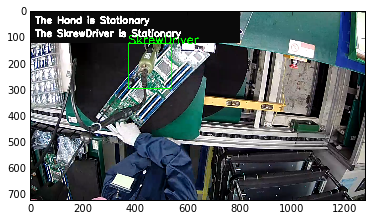

In [9]:
def f(x):
    plt.imshow(output2[x])

interact(f, x=35);